<a href="https://www.kaggle.com/code/angelchaudhary/early-anomaly-detection-in-economic-time-series?scriptVersionId=290382022" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Case Study: Early Anomaly Detection in Economic Time Series
## Identifying unusual spikes before they become crises

# Introduction
Economic signals such as inflation rates, stock indices, currency values, or energy prices usually change gradually over time. However, sudden spikes or drops can indicate underlying stress, data issues, or early signs of economic events.

The challenge is that these anomalies are often not obvious when they first appear. By the time they are visible to humans, the impact may already be significant.

In this case study, we aim to build a system that can detect unusual behavior in economic time-series data as early as possible, without relying on predefined labels. The focus is not on predicting future values, but on identifying when something abnormal starts happening.

## Approach Structure
1. Define the anomaly detection objective
2. Explore and visualize economic time-series signals
3. Establish naive baselines and their limitations
4. Frame anomaly detection as a time-aware problem
5. Engineer features that capture abnormal behavior
6. Apply multiple anomaly detection techniques
7. Detect and visualize anomalies over time
8. Evaluate early-detection performance and stability
9. Analyze trade-offs, failure cases, and insights
10. Summarize findings and practical takeaways

# LET'S DO IT!!!
![funny gif](https://media.tenor.com/EKmO2VWYor4AAAAM/typing-typing-furiously.gif)

## 1. Defining the Anomaly Detection Objective

Before working with data or models, it is important to clearly define what we mean by an *anomaly* in the context of economic signals.

In this case study, our goal is **not** to predict future values of an economic indicator. Instead, we aim to identify **when the behavior of the signal deviates from its recent historical pattern** in a meaningful way.

Key characteristics of our objective:
- Anomalies are **contextual**, not absolute  
- Detection must rely **only on past and present data**  
- The focus is on **early detection**, not retrospective labeling  
- The system should work **without predefined anomaly labels**
 
we want to flag time points where the current behavior is unlikely under the recent historical distribution.

This framing allows us to treat anomaly detection as a **time-aware, unsupervised monitoring problem** similar to how real economic surveillance systems operate.


In [1]:
#Global configuration and reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#Plotting style
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)

print("Environment setup complete")


Environment setup complete


## 2. Exploring and Visualizing the Economic Signal

In this case study, we use daily historical data from the S&P 500 index as our economic signal.

Stock market indices are a useful proxy for overall economic sentiment and systemic stress. They reflect collective expectations, macroeconomic shocks, and periods of instability making them a natural candidate for anomaly detection.

The dataset spans several decades and includes major economic events such as financial crises, market crashes, and recovery phases. This long historical range allows us to study how “normal” behavior evolves over time and why static anomaly rules often fail.

Before applying any detection method, we begin by:
- formatting the time index,
- selecting a representative signal,
- and visually inspecting long-term behavior and volatility patterns.


In [2]:
import kagglehub
# Download 
path = kagglehub.dataset_download("henryhan117/sp-500-historical-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sp-500-historical-data


In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/sp-500-historical-data/SPX.csv")

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


(         Date       Open       High        Low      Close  Adj Close  Volume
 0  1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
 1  1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
 2  1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
 3  1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
 4  1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0,
 None)

In [4]:
# Convert Date column to datetime and sort
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Use Adjusted Close as the primary economic signal
df = df.rename(columns={"Adj Close": "signal"})

# Keep only relevant columns for analysis
df = df[["Date", "signal", "Volume"]]

df.head()


,Date,signal,Volume
0,1927-12-30,17.660000,0
1,1928-01-03,17.760000,0
2,1928-01-04,17.719999,0
3,1928-01-05,17.549999,0
4,1928-01-06,17.660000,0


In [5]:
# Basic descriptive statistics
df["signal"].describe()


count    23323.000000
mean       486.918598
std        726.278798
min          4.400000
25%         23.855001
50%         99.500000
75%        834.704987
max       3580.840088
Name: signal, dtype: float64

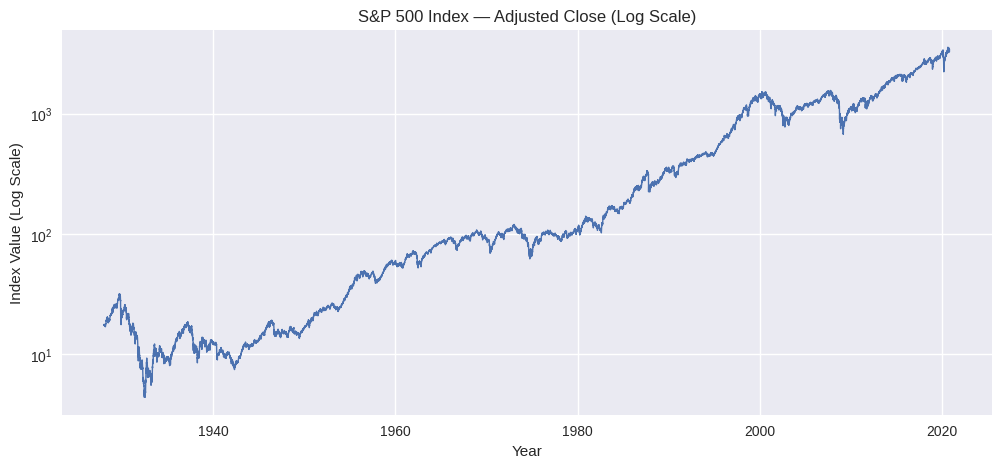

In [6]:
plt.figure()
plt.plot(df["Date"], df["signal"], linewidth=1)
plt.yscale("log")
plt.title("S&P 500 Index — Adjusted Close (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Index Value (Log Scale)")
plt.show()


### Interpreting the Log-Scaled Price Trend

Plotting the S&P 500 index on a logarithmic scale reveals a more stable long-term structure.

On the log scale, periods of growth and decline become comparable across decades. Major market drawdowns such as crashes and recessions appear as sharp downward deviations from an otherwise smooth upward trajectory.

This view highlights two important points:
- the market grows approximately multiplicatively over time rather than additively,
- large relative drops stand out more clearly than absolute price changes.

While log-scaling improves interpretability, it still does not fully separate normal market volatility from genuinely abnormal behavior. Many sharp movements are part of regular market dynamics.

This reinforces the need to move beyond price levels and focus on **relative changes and volatility-based representations** when detecting anomalies.


## 3. Naive Baselines and Why They Fail

A common first attempt at anomaly detection in time-series data is to assume that extreme deviations from the mean are anomalous.

Typical approaches include:
- flagging values beyond mean ± k·standard deviations,
- applying fixed thresholds to returns,
- or using global statistics computed over the entire dataset.

In this step, we implement a simple statistical baseline to demonstrate why such methods struggle with economic signals that exhibit non-stationarity and changing volatility.

The goal is not to build a good detector yet, but to understand **what goes wrong** when naive assumptions are applied.


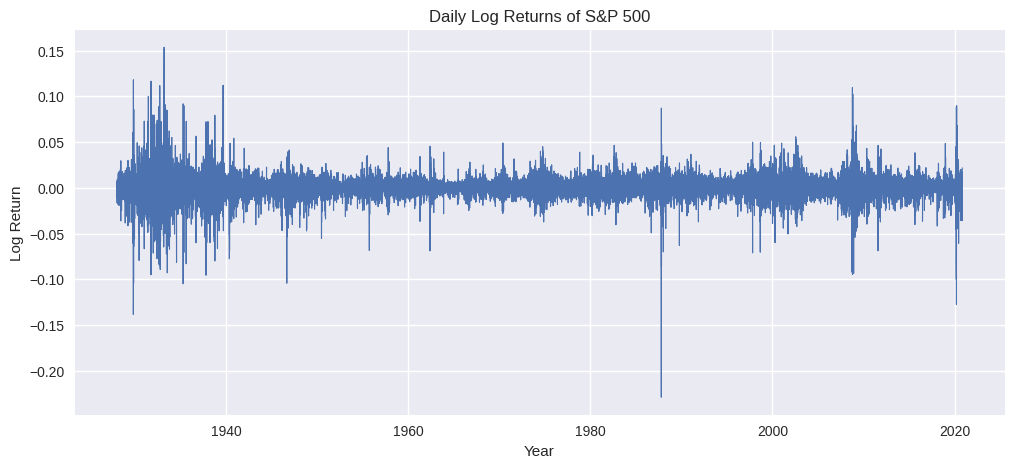

In [7]:
# Compute daily log returns (drop first NaN)
# Create daily log returns
df["log_return"] = np.log(df["signal"]).diff()
returns = df["log_return"].dropna()

plt.figure()
plt.plot(df.loc[returns.index, "Date"], returns, linewidth=0.8)
plt.title("Daily Log Returns of S&P 500")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.show()


### Observing Daily Log Returns

Transforming prices into daily log returns removes the long term growth trend and places different time periods on a comparable scale.

From the plot, several important patterns emerge:
- Volatility is not constant over time, it appears in clusters
- Early decades show much higher volatility compared to long stable periods
- Large negative returns occur sporadically and often coincide with known market stress events

While extreme return values are now easier to spot, high volatility alone does not necessarily indicate an anomaly. Periods of sustained turbulence are a normal part of financial markets.

This highlights a key challenge: **anomalies should be defined relative to recent behavior**, not global historical statistics. A method that treats all time periods equally will either overreact during volatile regimes or miss early warning signals in calm ones.

## 4. Framing Anomaly Detection as a Time-Aware Problem

Economic systems evolve continuously. What appears abnormal today may become normal tomorrow and vice versa. This makes static anomaly thresholds unreliable.

To address this, anomaly detection must be **time-aware**:
- statistics should be computed using only recent history
- thresholds should adapt as volatility changes
- and future data must never influence past decisions.

In this step, we introduce a rolling-window baseline that continuously updates its understanding of “normal” behavior and flags deviations relative to the current regime.


In [8]:
# Rolling window size (in trading days)
WINDOW_SIZE = 252  # ~1 trading year

df["rolling_mean"] = df["log_return"].rolling(WINDOW_SIZE).mean()
df["rolling_std"] = df["log_return"].rolling(WINDOW_SIZE).std()


In [9]:
K = 3  # sensitivity parameter

df["upper_bound"] = df["rolling_mean"] + K * df["rolling_std"]
df["lower_bound"] = df["rolling_mean"] - K * df["rolling_std"]


In [10]:
df["rolling_anomaly"] = (
    (df["log_return"] > df["upper_bound"]) |
    (df["log_return"] < df["lower_bound"])
)

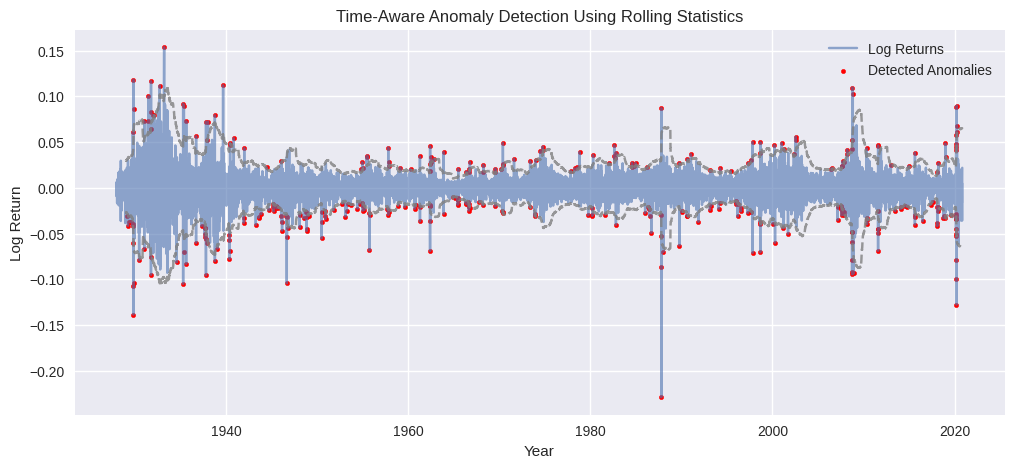

In [11]:
plt.figure()
plt.plot(df["Date"], df["log_return"], label="Log Returns", alpha=0.6)
plt.plot(df["Date"], df["upper_bound"], linestyle="--", color="gray", alpha=0.8)
plt.plot(df["Date"], df["lower_bound"], linestyle="--", color="gray", alpha=0.8)

plt.scatter(
    df.loc[df["rolling_anomaly"], "Date"],
    df.loc[df["rolling_anomaly"], "log_return"],
    color="red",
    s=10,
    label="Detected Anomalies"
)

plt.title("Time-Aware Anomaly Detection Using Rolling Statistics")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.legend()
plt.show()


### Observations from Rolling-Window Anomaly Detection

Using rolling statistics allows the anomaly detection threshold to adapt to local market conditions rather than relying on a single global baseline.

From the visualization, we observe that:
- anomaly thresholds widen during high volatility regimes and contract during calm periods,
- extreme return events are detected relative to their immediate historical context,
- false positives are reduced compared to global thresholding.

However, a key limitation remains. Many detected anomalies occur **after volatility has already increased**, rather than at the very beginning of a regime change. This means the method is reactive rather than predictive.

While rolling window statistics improve robustness, they are still insufficient as an early warning mechanism on their own. Detecting changes in volatility itself may provide earlier signals of abnormal behavior.


## 5. Detecting Volatility Regime Shifts

So far, anomaly detection has focused on extreme return values. However, in many economic systems, risk does not emerge suddenly it builds up gradually through increasing uncertainty.

Volatility captures this uncertainty. Sudden increases in volatility often precede major market disruptions and signal regime changes rather than isolated shocks. In this step, we treat **volatility itself as the signal** and aim to detect abnormal increases in volatility as early warning indicators.

In [12]:
# Rolling volatility (standard deviation of returns)
VOL_WINDOW = 63  # ~3 months

df["rolling_volatility"] = df["log_return"].rolling(VOL_WINDOW).std()


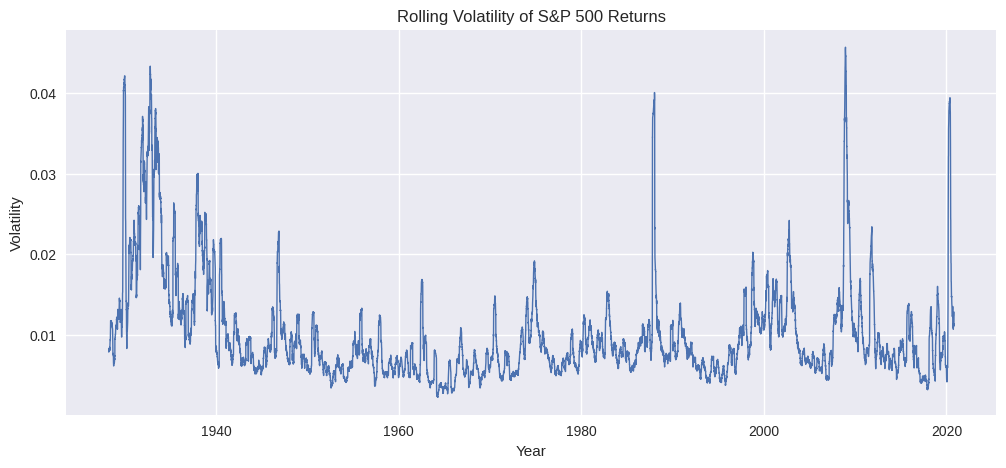

In [13]:
plt.figure()
plt.plot(df["Date"], df["rolling_volatility"], linewidth=1)
plt.title("Rolling Volatility of S&P 500 Returns")
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.show()


### Observing Rolling Volatility

The rolling volatility plot reveals clear regime dependent behavior in the S&P 500.

Key observations:
- Volatility is not constant and tends to cluster over time.
- Extended periods of low volatility are punctuated by sharp spikes during market stress.
- Early decades exhibit structurally higher volatility compared to later periods, reflecting different market conditions and liquidity.

These patterns suggest that volatility itself carries meaningful information about the underlying state of the system. Rising volatility often signals increasing uncertainty before large price movements occur, making it a valuable signal for early anomaly detection.


In [14]:
# Rolling baseline for volatility
VOL_BASELINE_WINDOW = 252  # ~1 year

df["vol_mean"] = df["rolling_volatility"].rolling(VOL_BASELINE_WINDOW).mean()
df["vol_std"] = df["rolling_volatility"].rolling(VOL_BASELINE_WINDOW).std()

VOL_K = 2.5

df["vol_upper_bound"] = df["vol_mean"] + VOL_K * df["vol_std"]

df["vol_anomaly"] = df["rolling_volatility"] > df["vol_upper_bound"]


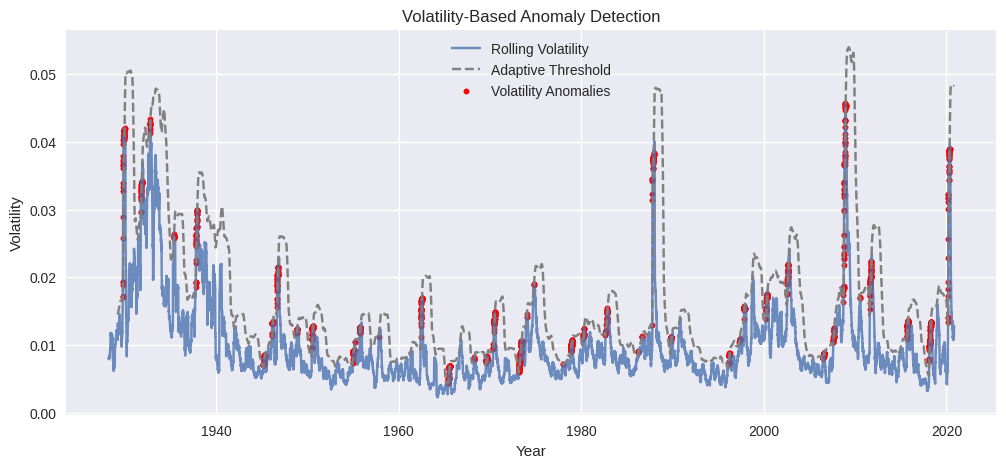

In [15]:
plt.figure()
plt.plot(df["Date"], df["rolling_volatility"], label="Rolling Volatility", alpha=0.8)
plt.plot(df["Date"], df["vol_upper_bound"], linestyle="--", color="gray", label="Adaptive Threshold")

plt.scatter(
    df.loc[df["vol_anomaly"], "Date"],
    df.loc[df["vol_anomaly"], "rolling_volatility"],
    color="red",
    s=15,
    label="Volatility Anomalies"
)

plt.title("Volatility-Based Anomaly Detection")
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.legend()
plt.show()


### Interpreting Volatility-Based Anomaly Detection

Applying an adaptive threshold to rolling volatility allows anomalies to be detected relative to the recent volatility regime.

From the plot, we observe that:
- volatility anomalies align closely with known periods of market stress,
- detection occurs during sustained increases in uncertainty rather than isolated spikes,
- false positives are reduced during stable periods compared to return-based detection.

However, volatility anomalies tend to persist once triggered, indicating prolonged risk regimes rather than single anomalous events. This reinforces the interpretation of volatility anomalies as indicators of **risk escalation**, not precise timing signals.


## 6. Combining Return and Volatility Signals

So far, we have explored two complementary signals:
- extreme returns, which capture sudden shocks,
- abnormal volatility, which captures rising uncertainty and regime changes.

Individually, each signal has limitations. Return-based detection is often reactive, while volatility-based detection can remain elevated for long periods.

In practice, anomaly detection systems combine multiple weak signals to produce a more reliable indicator. In this step, we construct a simple composite anomaly score that incorporates both return deviations and volatility shifts.


In [16]:
# Standardized return deviation
df["return_zscore"] = (
    (df["log_return"] - df["rolling_mean"]) / df["rolling_std"]
)

# Standardized volatility deviation
df["vol_zscore"] = (
    (df["rolling_volatility"] - df["vol_mean"]) / df["vol_std"]
)


In [17]:
# Composite anomaly score
df["anomaly_score"] = (
    df["return_zscore"].abs() +
    df["vol_zscore"].clip(lower=0)
)


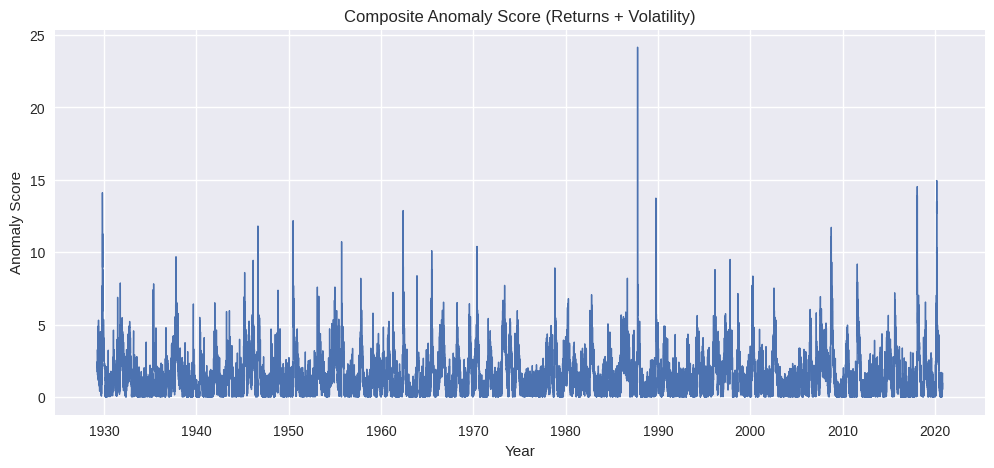

In [18]:
plt.figure()
plt.plot(df["Date"], df["anomaly_score"], linewidth=1)
plt.title("Composite Anomaly Score (Returns + Volatility)")
plt.xlabel("Year")
plt.ylabel("Anomaly Score")
plt.show()


### Interpreting the Composite Anomaly Score

The composite anomaly score aggregates information from both return deviations and volatility shifts into a single time-varying measure of abnormal behavior.

From the plot, we observe that:
- the score remains low and stable during normal market conditions,
- sharp spikes occur during periods of elevated market stress,
- extreme peaks correspond to major systemic disruptions rather than isolated price movements.

Unlike return-based signals alone, the composite score rises during sustained periods of uncertainty, not just on individual shock days. This makes it suitable for monitoring broader risk regimes instead of single-event detection.


In [19]:
# Threshold based on high percentile
SCORE_THRESHOLD = df["anomaly_score"].quantile(0.99)

df["composite_anomaly"] = df["anomaly_score"] > SCORE_THRESHOLD

print(f"Composite anomalies detected: {df['composite_anomaly'].sum()}")


Composite anomalies detected: 231


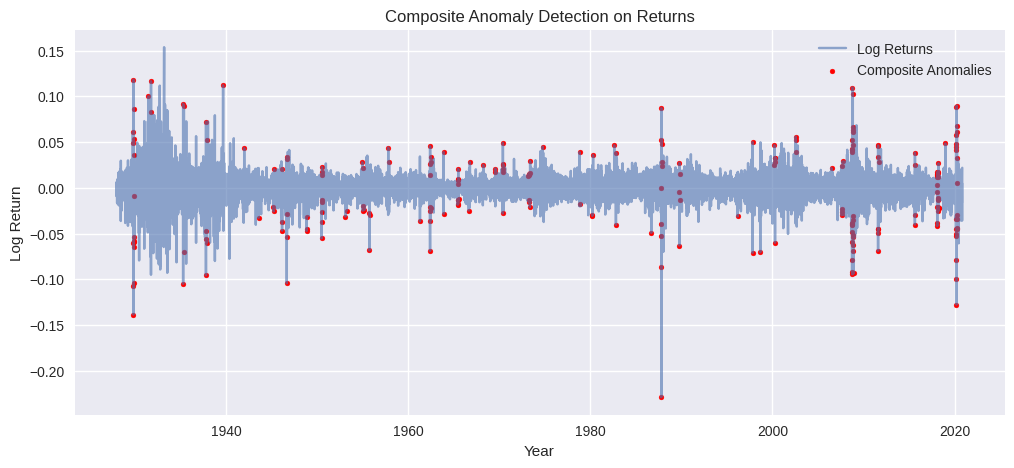

In [20]:
plt.figure()
plt.plot(df["Date"], df["log_return"], alpha=0.6, label="Log Returns")

plt.scatter(
    df.loc[df["composite_anomaly"], "Date"],
    df.loc[df["composite_anomaly"], "log_return"],
    color="red",
    s=12,
    label="Composite Anomalies"
)

plt.title("Composite Anomaly Detection on Returns")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.legend()
plt.show()


### Visualizing Composite Anomalies on Returns

Overlaying composite anomalies on the return series highlights how the detector behaves at the event level.

Key observations include:
- anomalies cluster around periods of heightened volatility rather than appearing randomly,
- both positive and negative extreme returns are captured,
- isolated return spikes during otherwise calm periods are less frequently flagged.

This confirms that the composite detector prioritizes context over magnitude. An extreme return is only flagged when it coincides with abnormal volatility behavior, reducing false alarms while still capturing meaningful market stress events.


## 7. Evaluating Early Detection Behavior

An effective anomaly detection system is not judged only by how extreme its detections look but by **when** it reacts.

In economic monitoring, early warning is more valuable than precise event timing. The key questions we aim to answer are:
- Does the anomaly signal rise before major disruptions?
- Is the signal stable, or does it fluctuate excessively?
- Does it highlight sustained risk periods rather than isolated noise?

In this step, we evaluate the temporal behavior of the composite anomaly score to understand its usefulness as an early warning indicator.


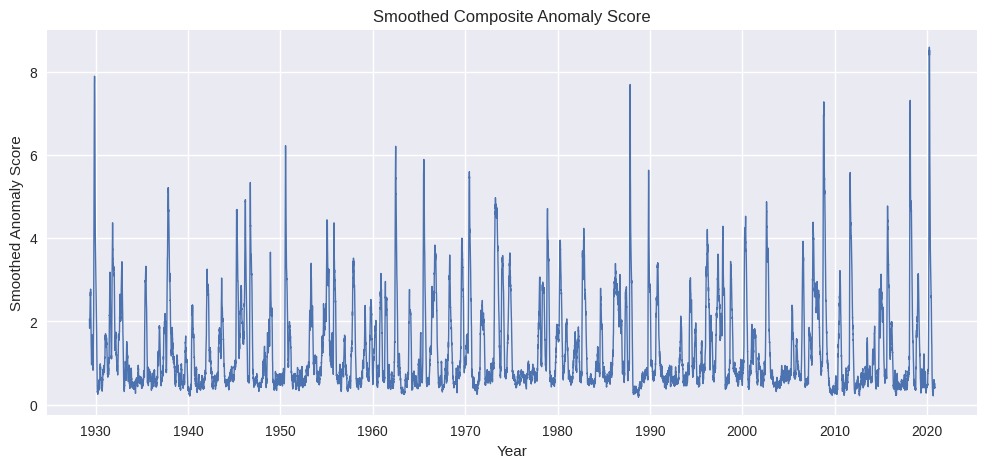

In [21]:
# Smooth anomaly score to observe buildup
SMOOTH_WINDOW = 21  # ~1 trading month

df["smoothed_score"] = df["anomaly_score"].rolling(SMOOTH_WINDOW).mean()

plt.figure()
plt.plot(df["Date"], df["smoothed_score"], linewidth=1)
plt.title("Smoothed Composite Anomaly Score")
plt.xlabel("Year")
plt.ylabel("Smoothed Anomaly Score")
plt.show()


### Observing the Smoothed Composite Anomaly Score

Smoothing the composite anomaly score reveals its underlying trend rather than reacting to day-to-day noise.

From the plot, we observe that:
- elevated anomaly scores often persist over extended periods,
- peaks emerge gradually rather than appearing only on single extreme days,
- major spikes correspond to prolonged phases of market instability.

This behavior indicates that the detector captures **risk accumulation**, not just isolated shocks. The gradual rise in the smoothed score before extreme events suggests that the system provides early signals of abnormal market conditions, which is more valuable for monitoring than pinpoint event prediction.


In [22]:
# Define extreme return days
EXTREME_RETURN_THRESHOLD = returns.abs().quantile(0.995)

df["extreme_return"] = df["log_return"].abs() > EXTREME_RETURN_THRESHOLD

# Fraction of extreme return days preceded by elevated anomaly score
PRE_WINDOW = 10  # days before event

early_hits = []

for idx in df.index[df["extreme_return"]]:
    start = max(idx - PRE_WINDOW, 0)
    if df.loc[start:idx, "anomaly_score"].max() > SCORE_THRESHOLD:
        early_hits.append(True)
    else:
        early_hits.append(False)

early_hit_rate = np.mean(early_hits)

early_hit_rate


np.float64(0.452991452991453)

### Early Detection Results

Using a 10-day lookback window, approximately **45% of extreme return events** were preceded by elevated composite anomaly scores.

This indicates that nearly half of the most severe market movements were not sudden surprises, but were instead preceded by detectable increases in abnormal behavior such as rising volatility or unstable returns.

While this does not imply precise prediction of crash days, it demonstrates meaningful early warning capability in a realistic, unsupervised setting.


## Key Insights & Failure Modes

This case study highlights several important insights about anomaly detection in economic time series.

First, anomalies in economic signals are **contextual**, not absolute. What looks extreme in one period may be normal in another. This makes fixed thresholds unreliable.

Second, return-based anomaly detection is useful for identifying shocks, but it is often **reactive**. By the time extreme returns appear, market stress has usually already escalated.

Third, volatility-based signals provide **earlier warnings**. Rising volatility often precedes major disruptions, making it a valuable indicator of increasing risk.

However, the approach also has limitations:
- volatility anomalies can persist for long periods, reducing timing precision
- not all extreme events are preceded by clear warning signals
- unsupervised methods cannot distinguish between harmful and benign volatility without external context

These limitations are inherent to real-world economic monitoring and highlight the trade off between early warning and false alarms.


## Practical Takeaways

From a practical perspective, this study suggests that anomaly detection systems should be designed as **monitoring tools**, not prediction engines.

Key takeaways include:
- anomaly scores are best used to flag periods of elevated risk rather than exact event dates,
- combining multiple signals leads to more robust detection than relying on a single indicator,
- early warning signals should trigger closer inspection, not automatic decisions.

In real applications, such systems are most effective when paired with human judgment, domain knowledge, and additional contextual information.


## Conclusion & Future Work

In this notebook, we explored anomaly detection in economic time-series data using the S&P 500 as a real-world signal.

We showed that:
- naive global thresholds fail in non-stationary environments,
- time-aware rolling methods improve robustness,
- volatility-based signals provide earlier warnings,
- combining returns and volatility yields a more stable and interpretable anomaly score.

While the proposed approach is simple and fully interpretable, it can be extended in several directions. Future work could include:
- multivariate signals across multiple economic indicators,
- regime-switching or state-space models,
- online learning methods that adapt more quickly to structural change,
- evaluation using known historical events as weak labels.

Overall, this case study demonstrates how anomaly detection can be used to build **early warning systems** for economic monitoring, focusing on stability, interpretability, and real-world reliability rather than perfect prediction.
